<a href="https://colab.research.google.com/github/LatiefDataVisionary/deep-learning-college-task/blob/main/tasks/week_5_tasks/Task_CNN_Scratch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Section 0: Initial Setup (Pengaturan Awal)**

Bagian ini untuk melakukan instalasi library penting yang mungkin belum ada di Colab dan menghubungkan Google Drive.

## **0.1. Install Libraries (Instalasi Library)**

Menginstal library `mtcnn` yang akan digunakan untuk deteksi wajah.

In [1]:
!pip install mtcnn opencv-python Pillow matplotlib pandas numpy scikit-learn tensorflow lz4
!pip install --upgrade Pillow
!pip install lz4

## **0.2. Mount Google Drive (Menghubungkan Google Drive)**

Menghubungkan notebook dengan Google Drive agar dapat mengakses dataset.

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## **Section 1: Import Libraries and Environment Setup (Impor Library dan Pengaturan Lingkungan)**

**Penjelasan:** Di sini kita akan mengimpor semua modul dan library yang dibutuhkan untuk keseluruhan proyek serta mendefinisikan variabel-variabel global seperti path direktori, ukuran gambar, dan parameter training.

### **1.1. Import Core Libraries (Impor Library Utama)**

**Penjelasan:** Mengimpor library utama seperti tensorflow, keras, numpy, matplotlib.pyplot, os, dan seaborn yang akan digunakan sepanjang proyek ini.

In [3]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, InputLayer, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import zipfile
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
import cv2
import glob
import shutil
import random
from PIL import Image

# Removed MTCNN import

# --- Helper Function for finding image files ---
def find_image_files_recursive(directory):
    """
    Finds all image files (jpg, jpeg, png) recursively within a directory.

    Args:
        directory (str): The root directory to search.

    Returns:
        list: A list of full paths to the image files found.
    """
    if not os.path.exists(directory):
        print(f"Warning: Directory not found for finding images: {directory}")
        return []

    image_extensions = ['.jpg', '.jpeg', '.png']
    all_files_recursive = glob.glob(os.path.join(directory, '**', '*.*'), recursive=True)
    image_files = [f for f in all_files_recursive if os.path.splitext(f)[1].lower() in image_extensions]
    return image_files

### **1.2. Define Configurations (Definisi Konfigurasi)**

**Penjelasan:** Mendefinisikan variabel-variabel konfigurasi yang akan digunakan di seluruh notebook, termasuk path ke dataset, ukuran gambar yang akan digunakan, ukuran batch untuk training, jumlah epoch, dan jumlah kelas (mahasiswa).

Link Dataset Google Drive: https://drive.google.com/drive/folders/1S5mRxYOfTPAmfqqFFLfbV_D5eWj5J9ox?usp=sharing

In [4]:
# Define Directory Paths (Definisi Path Direktori)
ZIP_PATH = '/content/drive/MyDrive/Dataset/Dataset Sistem Presensi Wajah V1.0.zip' # Path to the raw zip file in Google Drive
RAW_DATA_PATH = '/content/raw_dataset' # Directory to extract the raw dataset
PROCESSED_PATH = '/content/processed_dataset' # Directory to save the processed (face-detected) dataset

# Define Image Parameters (Definisi Parameter Gambar)
IMG_HEIGHT = 128 # Smaller size for custom CNN from scratch
IMG_WIDTH = 128
CHANNELS = 3 # RGB color images

# Define Training Parameters (Definisi Parameter Pelatihan)
BATCH_SIZE = 32
EPOCHS = 50 # Will be controlled by Early Stopping
# NUM_CLASSES will be determined later by the data generator

### **1.3. Extract Dataset (Ekstrak Dataset)**

**Penjelasan:** Mengekstrak file dataset dari Google Drive ke lingkungan Colab agar dapat diakses sebagai direktori biasa.

In [5]:
# Define the path to the zip file in Google Drive
zip_path = '/content/drive/MyDrive/Dataset/Dataset Sistem Presensi Wajah V1.0.zip'
extract_path = '/content/dataset' # Directory to extract the dataset

# Create the extraction directory if it doesn't exist
os.makedirs(extract_path, exist_ok=True)

# Extract the zip file
print(f"Extracting {zip_path} to {extract_path}...")
try:
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_path)
    print("Extraction complete.")
except FileNotFoundError:
    print(f"Error: Zip file not found at {zip_path}")
except zipfile.BadZipFile:
    print(f"Error: Could not open or read zip file at {zip_path}. It might be corrupted.")
except Exception as e:
    print(f"An error occurred during extraction: {e}")

# Update TRAIN_DIR and TEST_DIR to point to the extracted directories
# Based on the previous output, the extracted content is in a subfolder
extracted_subfolder = os.path.join(extract_path, 'Dataset Sistem Presensi Wajah V1.0')
TRAIN_DIR = os.path.join(extracted_subfolder, 'Data Train')
TEST_DIR = os.path.join(extracted_subfolder, 'Data Test')


print(f"Updated TRAIN_DIR: {TRAIN_DIR}")
print(f"Updated TEST_DIR: {TEST_DIR}")

# Verify that the directories exist after extraction
if os.path.exists(TRAIN_DIR):
    print(f"TRAIN_DIR exists: {TRAIN_DIR}")
else:
    print(f"Error: TRAIN_DIR not found after extraction at {TRAIN_DIR}")

if os.path.exists(TEST_DIR):
    print(f"TEST_DIR exists: {TEST_DIR}")
else:
    print(f"Error: TEST_DIR not found after extraction at {TEST_DIR}")

# Now it's safe to list contents if needed for verification after extraction
print(f"Contents of {extract_path} after extraction: {os.listdir(extract_path)}")

Extracting /content/drive/MyDrive/Dataset/Dataset Sistem Presensi Wajah V1.0.zip to /content/dataset...
Extraction complete.
Updated TRAIN_DIR: /content/dataset/Dataset Sistem Presensi Wajah V1.0/Data Train
Updated TEST_DIR: /content/dataset/Dataset Sistem Presensi Wajah V1.0/Data Test
TRAIN_DIR exists: /content/dataset/Dataset Sistem Presensi Wajah V1.0/Data Train
TEST_DIR exists: /content/dataset/Dataset Sistem Presensi Wajah V1.0/Data Test
Contents of /content/dataset after extraction: ['Dataset Sistem Presensi Wajah V1.0']


## **Section 2: Advanced Preprocessing - Face Detection and Cropping (Preprocessing Lanjutan - Deteksi dan Pemotongan Wajah)**

**Penjelasan:** Ini adalah tahap paling krusial dan merupakan upgrade utama. Kita akan memproses seluruh dataset mentah sekali jalan. Tujuannya adalah mendeteksi wajah di setiap gambar, memotongnya, dan menyimpannya ke struktur direktori baru yang bersih dan siap pakai. Proses ini menyelesaikan masalah distorsi aspect ratio dan noise latar belakang.

### **2.1. Unzip Raw Dataset (Ekstrak Dataset Mentah)**

**Penjelasan:** Mengekstrak file dataset mentah dari lokasi ZIP_PATH ke direktori RAW_DATA_PATH agar dapat diakses sebagai file gambar.

In [6]:
# Create the raw data extraction directory if it doesn't exist
os.makedirs(RAW_DATA_PATH, exist_ok=True)

# Extract the zip file to the raw data path
print(f"Extracting {ZIP_PATH} to {RAW_DATA_PATH}...")
try:
    with zipfile.ZipFile(ZIP_PATH, 'r') as zip_ref:
        zip_ref.extractall(RAW_DATA_PATH)
    print("Extraction complete.")
except FileNotFoundError:
    print(f"Error: Zip file not found at {ZIP_PATH}")
except zipfile.BadZipFile:
    print(f"Error: Could not open or read zip file at {ZIP_PATH}. It might be corrupted.")
except Exception as e:
    print(f"An error occurred during extraction: {e}")

# Verify contents of the extracted raw data directory
print(f"Contents of {RAW_DATA_PATH} after extraction: {os.listdir(RAW_DATA_PATH)}")

# Determine the actual path to the raw image files inside the extracted folder
# Assuming the zip contains a single main folder
extracted_items = os.listdir(RAW_DATA_PATH)
if len(extracted_items) == 1 and os.path.isdir(os.path.join(RAW_DATA_PATH, extracted_items[0])):
    ACTUAL_RAW_DATA_ROOT = os.path.join(RAW_DATA_PATH, extracted_items[0])
else:
    # If structure is different, you might need to adjust this
    ACTUAL_RAW_DATA_ROOT = RAW_DATA_PATH
    print("Warning: Extracted data structure is not a single subfolder. Assuming raw images are directly in RAW_DATA_PATH.")

print(f"Actual root directory for raw images: {ACTUAL_RAW_DATA_ROOT}")

# Find all image files recursively and store in a global variable
image_extensions = ['.jpg', '.jpeg', '.png']
ALL_RAW_IMAGE_FILES = glob.glob(os.path.join(ACTUAL_RAW_DATA_ROOT, '**', '*.*'), recursive=True)
ALL_RAW_IMAGE_FILES = [f for f in ALL_RAW_IMAGE_FILES if os.path.splitext(f)[1].lower() in image_extensions]

print(f"Found {len(ALL_RAW_IMAGE_FILES)} raw image files.")
if len(ALL_RAW_IMAGE_FILES) > 5:
    print("First 5 raw files:", ALL_RAW_IMAGE_FILES[:5])
elif len(ALL_RAW_IMAGE_FILES) > 0:
     print("Raw files:", ALL_RAW_IMAGE_FILES)
else:
    print("No raw image files found. Check ZIP_PATH and extraction process.")

# Update the global variable if needed
globals()['ALL_RAW_IMAGE_FILES'] = ALL_RAW_IMAGE_FILES
globals()['ACTUAL_RAW_DATA_ROOT'] = ACTUAL_RAW_DATA_ROOT

Extracting /content/drive/MyDrive/Dataset/Dataset Sistem Presensi Wajah V1.0.zip to /content/raw_dataset...
Extraction complete.
Contents of /content/raw_dataset after extraction: ['Dataset Sistem Presensi Wajah V1.0']
Actual root directory for raw images: /content/raw_dataset/Dataset Sistem Presensi Wajah V1.0
Found 2120 raw image files.
First 5 raw files: ['/content/raw_dataset/Dataset Sistem Presensi Wajah V1.0/Data Test/5221911012_Debora_10.jpg', '/content/raw_dataset/Dataset Sistem Presensi Wajah V1.0/Data Test/5231811021_NASHA SHINTA A.B.P_13.jpg', "/content/raw_dataset/Dataset Sistem Presensi Wajah V1.0/Data Test/5231811028_Ma'ruf Ndaru Sasono_04.jpg", '/content/raw_dataset/Dataset Sistem Presensi Wajah V1.0/Data Test/5231811033_Rama Panji Nararendra Cahaya_23.jpg', '/content/raw_dataset/Dataset Sistem Presensi Wajah V1.0/Data Test/5231911012.Thalita Revalyna Maharani.33.jpeg']


### **2.2. Initialize Face Detector (Inisialisasi Detektor Wajah)**

**Penjelasan:** Menginisialisasi model MTCNN yang akan digunakan untuk mendeteksi wajah pada setiap gambar.

In [7]:
# # Initialize MTCNN detector
# detector = MTCNN()
# print("MTCNN detector initialized.")

### **2.3. Prepare Processed Directory Structure (Siapkan Struktur Direktori Hasil Proses)**

**Penjelasan:** Membuat struktur direktori baru di PROCESSED_PATH untuk menyimpan gambar wajah yang sudah dideteksi dan dipotong. Struktur ini akan memiliki sub-folder untuk data training dan testing, dan di dalamnya akan ada sub-folder untuk setiap kelas (berdasarkan NIM).

In [8]:
# Clean up and create the processed data directories
if os.path.exists(PROCESSED_PATH):
    print(f"Removing existing processed data directory: {PROCESSED_PATH}")
    shutil.rmtree(PROCESSED_PATH)

os.makedirs(PROCESSED_PATH)
os.makedirs(os.path.join(PROCESSED_PATH, 'train'))
os.makedirs(os.path.join(PROCESSED_PATH, 'test'))
print(f"Created processed data directories: {PROCESSED_PATH}/train and {PROCESSED_PATH}/test")

# Get unique class names (NIMs) from the list of all raw filenames (obtained in step 2.1)
class_names = set()
if 'ALL_RAW_IMAGE_FILES' in globals():
    for filepath in ALL_RAW_IMAGE_FILES:
        filename = os.path.basename(filepath)
        if len(filename) >= 10:
            nim = filename[:10]
            class_names.add(nim)
else:
    print("Warning: ALL_RAW_IMAGE_FILES not found. Class names will not be extracted.")


class_names = sorted(list(class_names))


if not class_names:
    print("Error: No class names (NIMs) extracted from filenames. Check file naming convention and ALL_RAW_IMAGE_FILES.")
else:
    print(f"Found {len(class_names)} unique classes (NIMs).")
    # Create sub-folders for each class in train and test directories
    for class_name in class_names:
        os.makedirs(os.path.join(PROCESSED_PATH, 'train', class_name), exist_ok=True)
        os.makedirs(os.path.join(PROCESSED_PATH, 'test', class_name), exist_ok=True)
    print("Created class sub-folders in processed train and test directories.")

# Store class_names for later use
CLASS_NAMES = class_names

Created processed data directories: /content/processed_dataset/train and /content/processed_dataset/test
Found 53 unique classes (NIMs).
Created class sub-folders in processed train and test directories.


### **2.4. Run the Simple Cropping Pipeline (Jalankan Pipeline Pemotongan Sederhana)**

**Penjelasan:** Membuat dan menjalankan fungsi untuk memotong bagian tengah dari setiap gambar mentah dan menyimpannya ke struktur direktori yang sudah disiapkan di PROCESSED_PATH. Metode ini lebih cepat daripada deteksi wajah, namun mengasumsikan wajah berada di area tengah gambar. Data akan diproses sesuai dengan pembagian training dan testing asli.

In [9]:
def process_and_save_cropped_images_by_split(raw_source_dir, processed_dest_dir, img_width, img_height):
    """
    Processes raw images from a specific source directory (e.g., original train or test),
    crops a fixed region from the center, resizes, and saves to the specified processed
    destination directory based on NIM from filename, maintaining the original split.

    Args:
        raw_source_dir (str): Directory containing raw images for a specific split (e.g., Data Train or Data Test).
        processed_dest_dir (str): Destination directory for processed images of this split (e.g., processed/train or processed/test).
        img_width (int): Target width for processed images.
        img_height (int): Target height for processed images.
    """
    print(f"Starting simple cropping for split from {raw_source_dir} to {processed_dest_dir}...")

    # Find all image files recursively within the raw source directory using the helper function
    image_files = find_image_files_recursive(raw_source_dir)

    total_processed = 0
    total_skipped = 0
    files_to_process = len(image_files)

    if files_to_process == 0:
        print(f"No image files found in {raw_source_dir}. Skipping this split.")
        print(f"Simple cropping for split finished.")
        print(f"Total images processed and saved: {total_processed}")
        print(f"Total images skipped (could not read or process): {total_skipped}")
        return

    print(f"Found {files_to_process} images to process in {raw_source_dir}.")

    for i, filepath in enumerate(image_files):
        filename = os.path.basename(filepath)
        if len(filename) >= 10:
            nim = filename[:10]
            # Ensure NIM corresponds to an expected class (from the class_names identified earlier)
            if nim in CLASS_NAMES:
                 # Define the destination path, including the class subfolder
                 dest_class_dir = os.path.join(processed_dest_dir, nim)
                 # Ensure the class directory exists (created in step 2.3)
                 if not os.path.exists(dest_class_dir):
                     # This should not happen if step 2.3 ran correctly, but as a safeguard:
                     os.makedirs(dest_class_dir, exist_ok=True)
                     # print(f"Created missing class directory: {dest_class_dir}") # Uncomment for debugging

                 dest_filepath = os.path.join(dest_class_dir, filename)

                 try:
                    image = cv2.imread(filepath)
                    if image is None:
                        # print(f"Warning: Could not read image file: {filepath}. Skipping.") # Uncomment for detailed skips
                        total_skipped += 1
                        continue

                    # --- Simple Center Cropping Logic ---
                    # Determine the center of the image
                    center_x = image.shape[1] // 2
                    center_y = image.shape[0] // 2

                    # Determine crop size (e.g., based on target size, maybe with a margin)
                    # Let's try cropping a square region around the center
                    # A size roughly proportional to target size, maybe slightly larger
                    crop_size = min(image.shape[0], image.shape[1]) * 0.8 # Crop 80% of the smaller dimension

                    x1 = int(max(0, center_x - crop_size // 2))
                    y1 = int(max(0, center_y - crop_size // 2))
                    x2 = int(min(image.shape[1], center_x + crop_size // 2))
                    y2 = int(min(image.shape[0], center_y + crop_size // 2))

                    # Ensure crop dimensions match if possible, adjust if needed
                    # Let's just use the calculated bounded box
                    face_crop = image[y1:y2, x1:x2]


                    # Check if crop is valid (not empty)
                    if face_crop is not None and face_crop.size > 0:
                        # Resize the cropped image to target size
                        face_resized = cv2.resize(face_crop, (img_width, img_height))

                        # Save the processed face image
                        cv2.imwrite(dest_filepath, face_resized)
                        total_processed += 1
                    else:
                         # print(f"Warning: Cropped image is empty for {filepath}. Skipping.") # Uncomment for detailed skips
                         total_skipped += 1


                 except Exception as e:
                    # print(f"Error processing {filepath}: {e}. Skipping.") # Uncomment for detailed errors
                    total_skipped += 1
            else:
                # print(f"Warning: NIM not found in CLASS_NAMES for file {filename}. Skipping.") # Uncomment for debugging unknown NIMs
                total_skipped += 1
        else:
             # print(f"Warning: Filename {filename} is too short to extract NIM. Skipping.") # Uncomment for debugging short filenames
             total_skipped += 1


    print(f"\nSimple cropping for split finished.")
    print(f"Total images processed and saved: {total_processed}")
    print(f"Total images skipped (could not read or process): {total_skipped}")


# --- Run the pipeline for Train and Test splits ---

# Ensure ACTUAL_RAW_DATA_ROOT is correctly determined in step 2.1
if 'ACTUAL_RAW_DATA_ROOT' in globals() and os.path.exists(ACTUAL_RAW_DATA_ROOT):
    original_train_dir = os.path.join(ACTUAL_RAW_DATA_ROOT, 'Data Train')
    original_test_dir = os.path.join(ACTUAL_RAW_DATA_ROOT, 'Data Test')

    # Check if the original train/test directories exist within the extracted raw data
    if not os.path.exists(original_train_dir):
        print(f"Error: Original Train directory not found at {original_train_dir}. Cannot process train data.")
    else:
        process_and_save_cropped_images_by_split(original_train_dir,
                                                 os.path.join(PROCESSED_PATH, 'train'),
                                                 IMG_WIDTH, IMG_HEIGHT)

    if not os.path.exists(original_test_dir):
        print(f"Error: Original Test directory not found at {original_test_dir}. Cannot process test data.")
    else:
        process_and_save_cropped_images_by_split(original_test_dir,
                                                 os.path.join(PROCESSED_PATH, 'test'),
                                                 IMG_WIDTH, IMG_HEIGHT)

else:
    print("Error: ACTUAL_RAW_DATA_ROOT is not set or does not exist. Cannot run processing pipeline.")

Starting simple cropping for split from /content/raw_dataset/Dataset Sistem Presensi Wajah V1.0/Data Train to /content/processed_dataset/train...
Found 1696 images to process in /content/raw_dataset/Dataset Sistem Presensi Wajah V1.0/Data Train.

Simple cropping for split finished.
Total images processed and saved: 1696
Total images skipped (could not read or process): 0
Starting simple cropping for split from /content/raw_dataset/Dataset Sistem Presensi Wajah V1.0/Data Test to /content/processed_dataset/test...
Found 424 images to process in /content/raw_dataset/Dataset Sistem Presensi Wajah V1.0/Data Test.

Simple cropping for split finished.
Total images processed and saved: 424
Total images skipped (could not read or process): 0


### **2.5. Verify Processed Dataset (Verifikasi Dataset Hasil Proses)**

**Penjelasan:** Memeriksa jumlah gambar di direktori training dan testing yang sudah diproses untuk memastikan bahwa pipeline deteksi dan pemotongan wajah berjalan dengan sukses dan data tersimpan dengan benar.

In [10]:
# Function to count images in a directory, including subdirectories
def count_images_in_directory(directory):
    count = 0
    if not os.path.exists(directory):
        return 0
    for root, _, files in os.walk(directory):
        for file in files:
            if file.lower().endswith(('.jpg', '.jpeg', '.png')):
                count += 1
    return count

# Count images in processed train and test directories
train_count = count_images_in_directory(os.path.join(PROCESSED_PATH, 'train'))
test_count = count_images_in_directory(os.path.join(PROCESSED_PATH, 'test'))

print(f"Number of processed images in training directory ({os.path.join(PROCESSED_PATH, 'train')}): {train_count}")
print(f"Number of processed images in testing directory ({os.path.join(PROCESSED_PATH, 'test')}): {test_count}")

if train_count == 0 or test_count == 0:
    print("Warning: No processed images found in one or both directories. Check the processing pipeline and file paths.")
else:
    print("Processed dataset structure verified.")

Number of processed images in training directory (/content/processed_dataset/train): 1696
Number of processed images in testing directory (/content/processed_dataset/test): 424
Processed dataset structure verified.


### **2.6. Inspect Class Distribution (Inspeksi Distribusi Kelas)**

**Penjelasan:** Memeriksa sebaran jumlah gambar untuk setiap kelas (NIM) di dataset yang sudah diproses. Ini penting untuk mengetahui apakah dataset memiliki distribusi kelas yang seimbang atau tidak.

Training Class Distribution:


,0
5221911012,32
5221911025,32
5231811002,32
5231811004,32
5231811005,32
5231811006,32
5231811007,32
5231811008,32
5231811009,32
5231811010,32



Total training images: 1696

Testing Class Distribution:


,0
5221911012,8
5221911025,8
5231811002,8
5231811004,8
5231811005,8
5231811006,8
5231811007,8
5231811008,8
5231811009,8
5231811010,8



Total testing images: 424


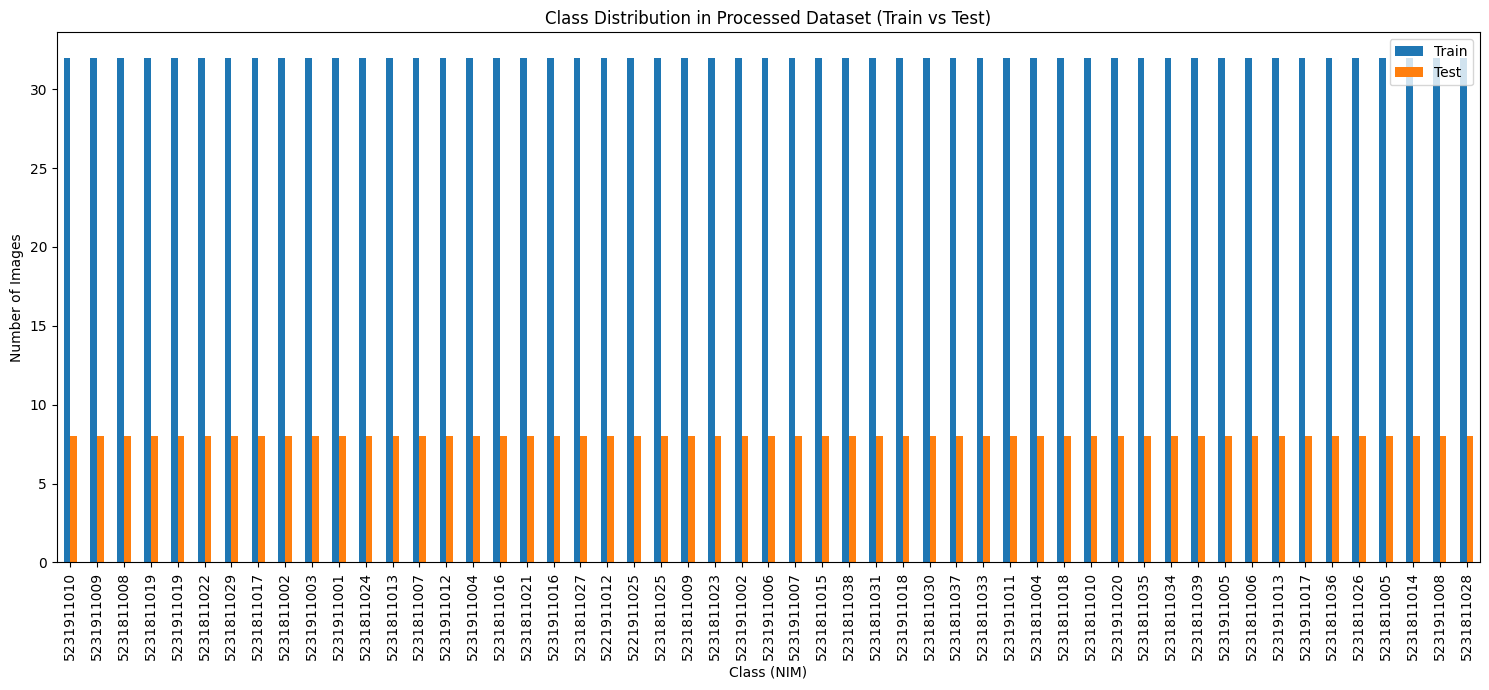

In [11]:
# Function to count images per class in a directory
def count_images_per_class(directory):
    class_counts = {}
    if not os.path.exists(directory):
        print(f"Warning: Directory not found: {directory}")
        return class_counts

    # List all items in the directory (should be class folders)
    class_folders = [d for d in os.listdir(directory) if os.path.isdir(os.path.join(directory, d))]

    if not class_folders:
        print(f"No class subfolders found in {directory}.")
        return class_counts

    for class_name in class_folders:
        class_path = os.path.join(directory, class_name)
        # Count image files within each class folder
        image_files = glob.glob(os.path.join(class_path, '*.*'))
        image_extensions = ['.jpg', '.jpeg', '.png']
        class_images = [f for f in image_files if os.path.splitext(f)[1].lower() in image_extensions]
        class_counts[class_name] = len(class_images)

    return class_counts

# Count images per class for training and testing data
train_class_counts = count_images_per_class(os.path.join(PROCESSED_PATH, 'train'))
test_class_counts = count_images_per_class(os.path.join(PROCESSED_PATH, 'test'))

print("Training Class Distribution:")
if train_class_counts:
    train_counts_df = pd.Series(train_class_counts)
    display(train_counts_df.sort_index())
    print(f"\nTotal training images: {train_counts_df.sum()}")
else:
    print("No training data found in processed directory.")

print("\nTesting Class Distribution:")
if test_class_counts:
    test_counts_df = pd.Series(test_class_counts)
    display(test_counts_df.sort_index())
    print(f"\nTotal testing images: {test_counts_df.sum()}")
else:
    print("No testing data found in processed directory.")

# Optional: Plot distribution
if train_class_counts or test_class_counts:
    all_class_names = sorted(list(set(train_class_counts.keys()) | set(test_class_counts.keys())))
    all_counts = pd.DataFrame({'Train': pd.Series(train_class_counts), 'Test': pd.Series(test_class_counts)}).fillna(0)

    if not all_counts.empty:
        all_counts.plot(kind='bar', figsize=(15, 7))
        plt.title("Class Distribution in Processed Dataset (Train vs Test)")
        plt.xlabel("Class (NIM)")
        plt.ylabel("Number of Images")
        plt.xticks(rotation=90)
        plt.tight_layout()
        plt.show()
    else:
        print("No data to plot distribution.")

### **2.7. Visualize Sample Images (Visualisasi Contoh Gambar)**

**Penjelasan:** Menampilkan beberapa contoh gambar acak dari dataset yang sudah diproses (training atau testing) untuk visualisasi dan memastikan proses deteksi wajah serta cropping berjalan sesuai harapan.

Visualizing samples from TRAINING data:
Displaying 15 random sample images...


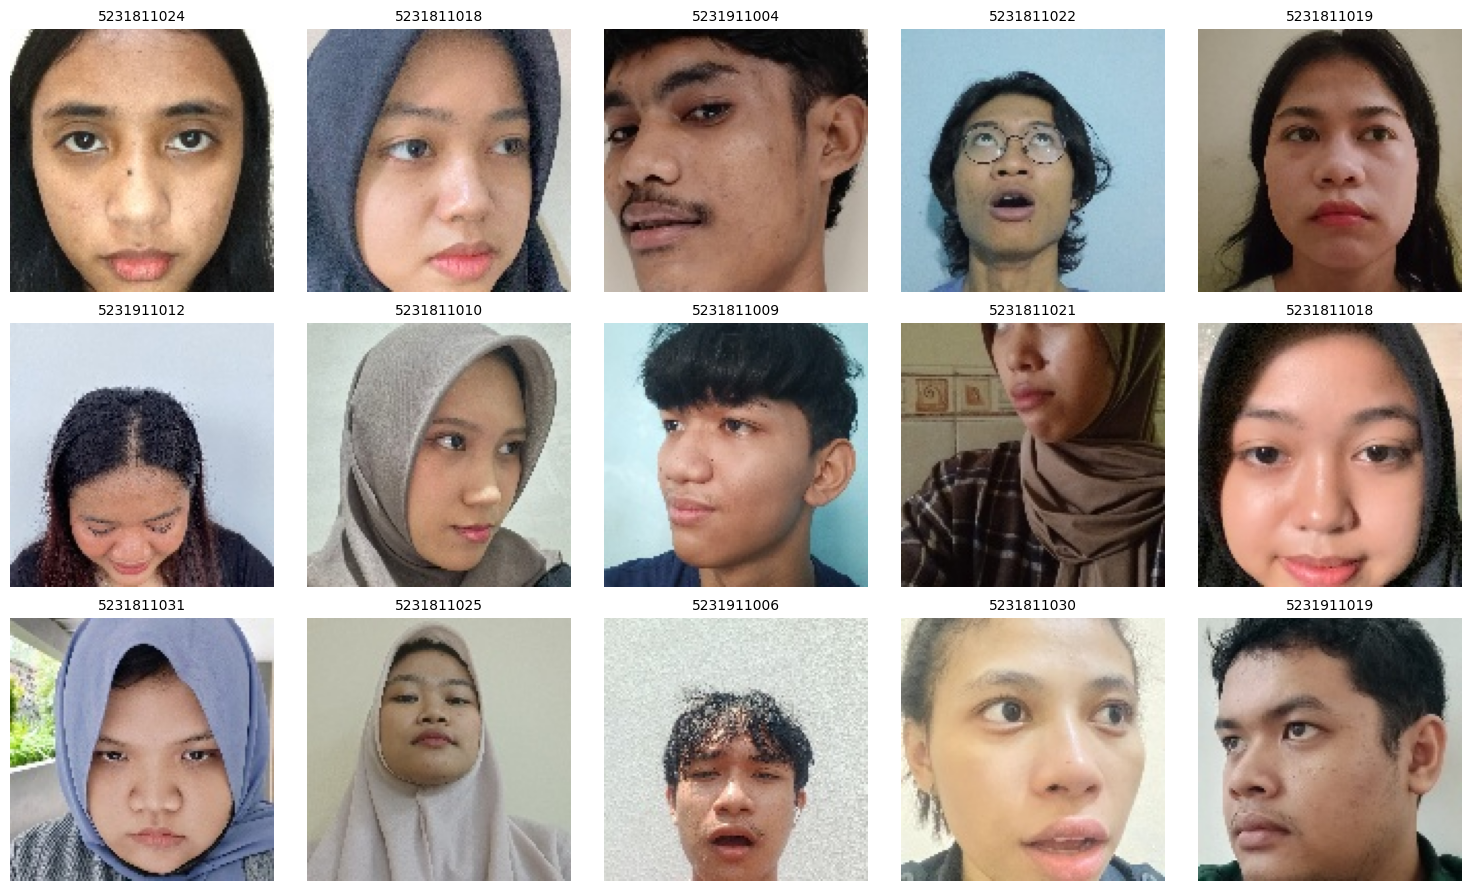


Visualizing samples from TESTING data:
Displaying 5 random sample images...


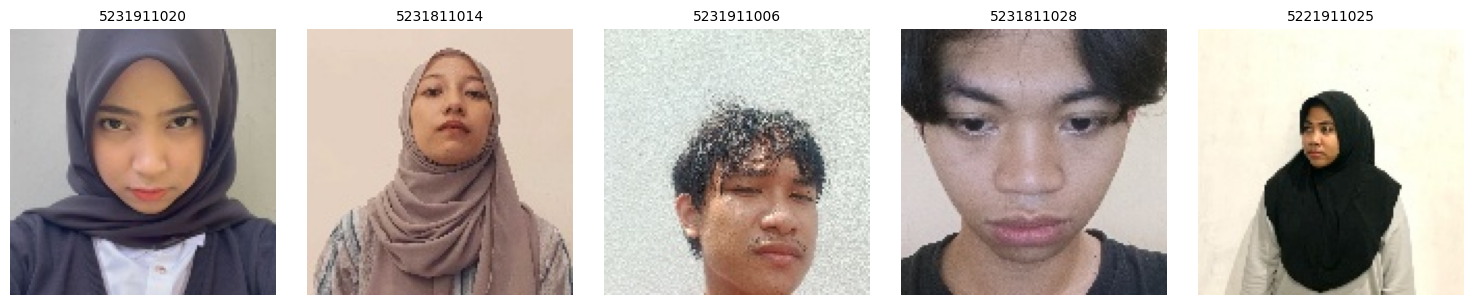

In [12]:
def visualize_sample_images(directory, num_samples=20):
    """
    Collects paths of a random sample of images from class subfolders
    and displays them in a grid.

    Args:
        directory (str): The root directory of the dataset split (e.g., PROCESSED_PATH/train).
        num_samples (int): The number of random images to display.
    """
    print(f"Collecting sample images from {directory}...")

    all_image_paths = []
    image_extensions = ['.jpg', '.jpeg', '.png']

    # Find all image files recursively within the directory
    if os.path.exists(directory):
        for root, _, files in os.walk(directory):
            for file in files:
                if os.path.splitext(file)[1].lower() in image_extensions:
                    all_image_paths.append(os.path.join(root, file))
    else:
        print(f"Directory not found: {directory}")
        return

    if not all_image_paths:
        print(f"No image files found in {directory}.")
        return

    # Select random samples
    num_samples = min(num_samples, len(all_image_paths)) # Don't ask for more samples than available
    sample_paths = random.sample(all_image_paths, num_samples)

    print(f"Displaying {num_samples} random sample images...")

    # Determine grid size
    cols = 5 # Number of columns in the grid
    rows = (num_samples + cols - 1) // cols # Calculate number of rows needed

    plt.figure(figsize=(cols * 3, rows * 3)) # Adjust figure size based on grid

    for i, img_path in enumerate(sample_paths):
        try:
            img = Image.open(img_path).convert('RGB')
            plt.subplot(rows, cols, i + 1)
            plt.imshow(img)
            plt.title(os.path.basename(os.path.dirname(img_path)), fontsize=10) # Title with Class Name (NIM)
            plt.axis('off')
        except Exception as e:
            print(f"Could not load image {img_path}: {e}")
            plt.subplot(rows, cols, i + 1)
            plt.text(0.5, 0.5, 'Error', ha='center', va='center')
            plt.axis('off')


    plt.tight_layout()
    plt.show()

# --- Visualize samples from both train and test (optional) ---
# Adjust the directories and number of samples as needed

print("Visualizing samples from TRAINING data:")
visualize_sample_images(os.path.join(PROCESSED_PATH, 'train'), num_samples=15)

print("\nVisualizing samples from TESTING data:")
visualize_sample_images(os.path.join(PROCESSED_PATH, 'test'), num_samples=5) # Display fewer test samples

## **Section 3: Data Loading and Augmentation (Pemuatan dan Augmentasi Data)**


**Penjelasan**: Sekarang kita akan bekerja dengan data yang sudah bersih di PROCESSED_PATH. Karena datanya sudah memiliki struktur folder per kelas, kita bisa menggunakan flow_from_directory yang lebih efisien.


### **3.1. Create Data Generators (Membuat Generator Data)**

**Penjelasan:** Menginisialisasi `ImageDataGenerator` untuk data training dengan berbagai teknik augmentasi untuk meningkatkan variasi data dan membantu mencegah overfitting. Satu generator terpisah dibuat untuk data testing yang hanya melakukan rescaling.

In [13]:
# Create ImageDataGenerator for training with augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,             # Rescale pixel values to [0, 1]
    rotation_range=20,          # Randomly rotate images by up to 20 degrees
    width_shift_range=0.2,      # Randomly shift image horizontally
    height_shift_range=0.2,     # Randomly shift image vertically
    shear_range=0.2,            # Apply shear transformation
    zoom_range=0.2,             # Apply random zoom
    horizontal_flip=True,       # Randomly flip images horizontally
    fill_mode='nearest'         # Fill pixels lost during transformations
)

# Create ImageDataGenerator for testing (only rescaling)
test_datagen = ImageDataGenerator(rescale=1./255) # Only rescale for consistency

### **3.2. Apply the Generators (Menerapkan Generator)**

**Penjelasan:** Menggunakan metode `flow_from_directory` dari generator yang telah dibuat untuk membaca gambar langsung dari struktur folder di PROCESSED_PATH/train dan PROCESSED_PATH/test. Ini secara otomatis akan menentukan label kelas berdasarkan nama sub-folder.

In [14]:
# Create training data generator
train_generator = train_datagen.flow_from_directory(
    os.path.join(PROCESSED_PATH, 'train'),
    target_size=(IMG_WIDTH, IMG_HEIGHT), # Target size for input images
    batch_size=BATCH_SIZE,
    color_mode='rgb',
    class_mode='categorical' # For multi-class classification
)

# Create testing data generator
test_generator = test_datagen.flow_from_directory(
    os.path.join(PROCESSED_PATH, 'test'),
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    batch_size=BATCH_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    shuffle=False # Keep data in order for evaluation metrics
)

# Get the number of classes from the training generator
NUM_CLASSES = train_generator.num_classes
print(f"\nNumber of classes (detected from directories): {NUM_CLASSES}")
print(f"Class indices: {train_generator.class_indices}")

# You can also store the class names if needed
CLASS_NAMES_GENERATOR = list(train_generator.class_indices.keys())
print(f"Class names (order corresponds to indices): {CLASS_NAMES_GENERATOR}")

Found 1696 images belonging to 53 classes.
Found 424 images belonging to 53 classes.

Number of classes (detected from directories): 53
Class indices: {'5221911012': 0, '5221911025': 1, '5231811002': 2, '5231811004': 3, '5231811005': 4, '5231811006': 5, '5231811007': 6, '5231811008': 7, '5231811009': 8, '5231811010': 9, '5231811013': 10, '5231811014': 11, '5231811015': 12, '5231811016': 13, '5231811017': 14, '5231811018': 15, '5231811019': 16, '5231811021': 17, '5231811022': 18, '5231811023': 19, '5231811024': 20, '5231811025': 21, '5231811026': 22, '5231811027': 23, '5231811028': 24, '5231811029': 25, '5231811030': 26, '5231811031': 27, '5231811033': 28, '5231811034': 29, '5231811035': 30, '5231811036': 31, '5231811037': 32, '5231811038': 33, '5231811039': 34, '5231911001': 35, '5231911002': 36, '5231911003': 37, '5231911004': 38, '5231911005': 39, '5231911006': 40, '5231911007': 41, '5231911008': 42, '5231911009': 43, '5231911010': 44, '5231911011': 45, '5231911012': 46, '5231911013'

## **Section 4: Modeling (From Scratch) (Pembuatan Model dari Dasar)**

**Penjelasan:** Di sini kita akan membangun arsitektur Convolutional Neural Network (CNN) dasar dari awal, tanpa menggunakan model pre-trained atau transfer learning. Arsitekturnya akan mengikuti pola umum Conv -> Pool -> BatchNorm -> Dropout -> Dense layers.

### **4.1. Build the CNN Architecture (Membangun Arsitektur CNN)**

**Penjelasan:** Menggunakan Keras Sequential API untuk menumpuk layer-layer CNN dan Dense. Arsitektur ini didesain untuk menangani input gambar berukuran (IMG_WIDTH, IMG_HEIGHT, CHANNELS) dan mengklasifikasikan ke dalam NUM_CLASSES kategori.

In [15]:
# Define the input shape
input_shape = (IMG_WIDTH, IMG_HEIGHT, CHANNELS)

# Build the Sequential model
model = Sequential([
    # Input Layer (optional but good practice)
    InputLayer(input_shape=input_shape),

    # Block 1
    Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25), # Increased dropout after pooling

    # Block 2
    Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),

    # Block 3
    Conv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),

    # Flatten Layer
    Flatten(),

    # Dense Layers
    Dense(units=128, activation='relu'),
    BatchNormalization(), # Added Batch Normalization before final dropout
    Dropout(0.5), # Stronger dropout before the output layer

    # Output Layer
    Dense(units=NUM_CLASSES, activation='softmax') # NUM_CLASSES from data generator
])

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


### **4.2. Compile the Model (Kompilasi Model)**

**Penjelasan:** Mengkonfigurasi model untuk proses pelatihan dengan menentukan optimizer (Adam), fungsi loss (categorical crossentropy untuk klasifikasi multi-kelas), dan metrik evaluasi (akurasi).

In [16]:
# Compile the model
model.compile(optimizer=Adam(),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

### **4.3. Display Model Summary (Tampilkan Rangkuman Model)**

**Penjelasan:** Menampilkan struktur arsitektur model, jumlah parameter di setiap layer, dan total parameter model. Ini membantu dalam memahami kompleksitas model.

In [17]:
# Display the model summary
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 128, 128, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128, 128, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 32768)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     4,194,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 53)             │         6,837 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,295,925 (16.39 MB)

 Trainable params: 4,295,221 (16.38 MB)

 Non-trainable params: 704 (2.75 KB)

## **Section 5: Model Training (Pelatihan Model)**

**Penjelasan:** Melatih model CNN yang telah kita bangun menggunakan data dari generator. Kita akan menggunakan callbacks untuk mengoptimalkan proses pelatihan, seperti menghentikan pelatihan lebih awal jika tidak ada peningkatan performa dan menyimpan model terbaik.

### **5.1. Define Callbacks (Definisi Callbacks)**

**Penjelasan:** Menginisialisasi Keras Callbacks yang akan digunakan selama proses pelatihan. `ModelCheckpoint` akan menyimpan bobot model terbaik berdasarkan metrik validasi, dan `EarlyStopping` akan menghentikan pelatihan jika performa pada data validasi tidak membaik setelah beberapa epoch untuk mencegah overfitting.

In [18]:
# Define callbacks
# Create a directory to save model checkpoints
checkpoint_dir = '/content/checkpoints'
os.makedirs(checkpoint_dir, exist_ok=True)

# Use .keras format for saving model weights (recommended format)
model_checkpoint = ModelCheckpoint(
    filepath=os.path.join(checkpoint_dir, 'best_model.keras'), # Changed format to .keras
    monitor='val_accuracy', # Monitor validation accuracy
    save_best_only=True,   # Only save the best model based on the monitored metric
    mode='max',            # 'max' mode means we want to maximize val_accuracy
    verbose=1              # Print messages when a new best model is saved
)

early_stopping = EarlyStopping(
    monitor='val_loss',   # Monitor validation loss
    patience=10,          # Number of epochs with no improvement after which training will be stopped
    mode='min',           # 'min' mode means we want to minimize val_loss
    verbose=1             # Print messages when early stopping is triggered
)

# You can also add ReduceLROnPlateau if needed, but let's start simple
# reduce_lr = ReduceLROnPlateau(
#     monitor='val_loss',
#     factor=0.1,
#     patience=5,
#     mode='min',
#     verbose=1
# )

callbacks_list = [model_checkpoint, early_stopping] #, reduce_lr]

### **5.2. Start Training (Mulai Pelatihan)**

**Penjelasan:** Memulai proses pelatihan model menggunakan metode `model.fit()`. Data training dan validasi disediakan oleh generator yang telah dibuat di Section 3. Callbacks yang didefinisikan di sub-bagian sebelumnya akan diterapkan selama pelatihan.

In [19]:
# Start training the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // BATCH_SIZE, # Number of steps per epoch
    epochs=EPOCHS,
    validation_data=test_generator,
    validation_steps=test_generator.samples // BATCH_SIZE, # Number of validation steps
    callbacks=callbacks_list
)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.0895 - loss: 4.1491
Epoch 1: val_accuracy improved from -inf to 0.01923, saving model to /content/checkpoints/best_model.keras
53/53 ━━━━━━━━━━━━━━━━━━━━ 129s 2s/step - accuracy: 0.0902 - loss: 4.1403 - val_accuracy: 0.0192 - val_loss: 24.8253
Epoch 2/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.2359 - loss: 2.8475
Epoch 2: val_accuracy did not improve from 0.01923
53/53 ━━━━━━━━━━━━━━━━━━━━ 134s 3s/step - accuracy: 0.2368 - loss: 2.8446 - val_accuracy: 0.0192 - val_loss: 44.8468
Epoch 3/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.3915 - loss: 2.3060
Epoch 3: val_accuracy did not improve from 0.01923
53/53 ━━━━━━━━━━━━━━━━━━━━ 132s 2s/step - accuracy: 0.3918 - loss: 2.3047 - val_accuracy: 0.0192 - val_loss: 51.3131
Epoch 4/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.4933 - loss: 1.9642
Epoch 4: val_accuracy improved from 0.01923 to 0.03606, saving model to /content/checkpoints/best_model.kera

## **Section 6: Evaluation and Analysis (Evaluasi dan Analisis)**

**Penjelasan:** Menganalisis performa model baseline setelah pelatihan selesai.

### **6.1. Plot Training History (Plot Riwayat Pelatihan)**

**Penjelasan:** Membuat plot untuk visualisasi riwayat pelatihan model, termasuk akurasi dan loss pada data training dan validasi per epoch. Ini membantu dalam mengidentifikasi apakah model mengalami overfitting atau underfitting.

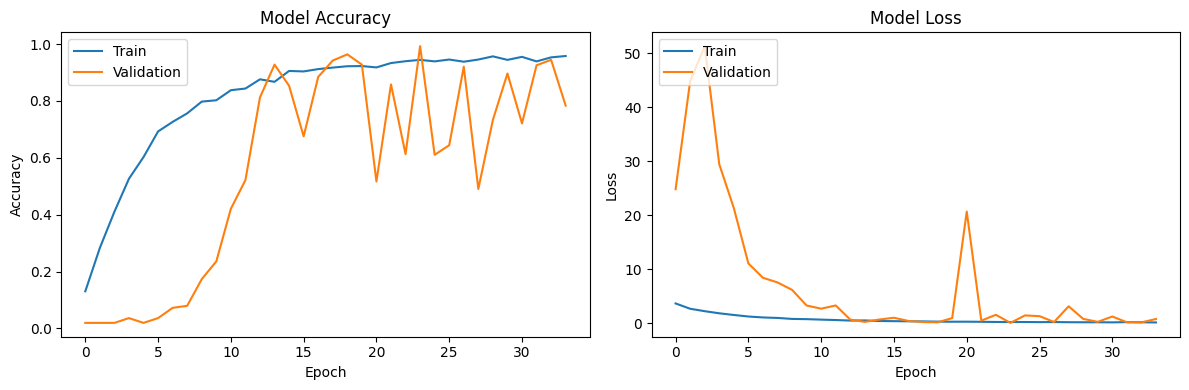

In [20]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

### **6.2. Evaluate on Test Data (Evaluasi pada Data Tes)**

**Penjelasan:** Memuat bobot model terbaik yang disimpan selama pelatihan (berdasarkan `ModelCheckpoint`) dan mengevaluasi performanya menggunakan data testing untuk mendapatkan metrik akurasi dan loss akhir pada data yang belum pernah dilihat model sebelumnya.

In [23]:
# Load the best model weights
# Update path to use the recommended .keras format
best_model_path = os.path.join(checkpoint_dir, 'best_model.keras') # Changed format to .keras

if os.path.exists(best_model_path):
    print(f"Loading best model from {best_model_path}...")
    # Use keras.models.load_model for the .keras format which loads the full model (architecture + weights + optimizer)
    # If you only want to load weights, you might need a different approach or ensure the model architecture is defined first
    # For simplicity with .keras, loading the full model is common
    try:
        # Re-define the model architecture first, then load weights if needed,
        # or load the full model if saved as such.
        # Since ModelCheckpoint saved weights only, we need the model architecture defined.
        # Let's assume the model architecture from Section 4 is already defined.
        model.load_weights(best_model_path) # Try loading weights into the existing model object
        print("Best model weights loaded.")
    except Exception as e:
         print(f"Error loading weights into existing model: {e}")
         print(f"Attempting to load full model from {best_model_path}...")
         try:
             # If saved the full model (unlikely with save_best_only=True and .weights.h5/keras)
             # This path is less likely for the original request but kept for robustness
             model = keras.models.load_model(best_model_path)
             print("Full best model loaded.")
         except Exception as e_full:
             print(f"Error loading full model: {e_full}")
             print(f"Warning: Could not load best model from {best_model_path}. Using the last trained model weights in memory.")


else:
    print(f"Warning: Best model not found at {best_model_path}. Using the last trained model weights in memory.")

# Evaluate the model on the test dataset
print("\nEvaluating model on test data...")
# Ensure model is compiled before evaluating if loading only weights
# If full model was loaded, it's already compiled
# If only weights were loaded, compilation is needed if it wasn't done after defining the model
# Assuming model was compiled in Section 4.2:
loss, accuracy = model.evaluate(test_generator) # Removed steps

print(f"\nTest Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

Loading best model from /content/checkpoints/best_model.keras...
Best model weights loaded.

Evaluating model on test data...
14/14 ━━━━━━━━━━━━━━━━━━━━ 5s 369ms/step - accuracy: 0.9942 - loss: 0.0584

Test Loss: 0.0719
Test Accuracy: 0.9929


### **6.3. Generate Classification Report and Confusion Matrix (Buat Laporan Klasifikasi dan Matriks Kebingungan)**

**Penjelasan:** Menghasilkan laporan klasifikasi yang berisi metrik presisi, recall, f1-score, dan support untuk setiap kelas, serta matriks kebingungan (confusion matrix) untuk memvisualisasikan performa model dalam mengklasifikasikan setiap kelas.

Generating predictions on test data...
14/14 ━━━━━━━━━━━━━━━━━━━━ 7s 446ms/step

Classification Report:
              precision    recall  f1-score   support

  5221911012       1.00      1.00      1.00         8
  5221911025       1.00      1.00      1.00         8
  5231811002       1.00      1.00      1.00         8
  5231811004       1.00      1.00      1.00         8
  5231811005       1.00      1.00      1.00         8
  5231811006       1.00      1.00      1.00         8
  5231811007       1.00      1.00      1.00         8
  5231811008       1.00      1.00      1.00         8
  5231811009       1.00      1.00      1.00         8
  5231811010       1.00      1.00      1.00         8
  5231811013       1.00      1.00      1.00         8
  5231811014       1.00      1.00      1.00         8
  5231811015       1.00      1.00      1.00         8
  5231811016       1.00      1.00      1.00         8
  5231811017       1.00      0.88      0.93         8
  5231811018       1.00      1.

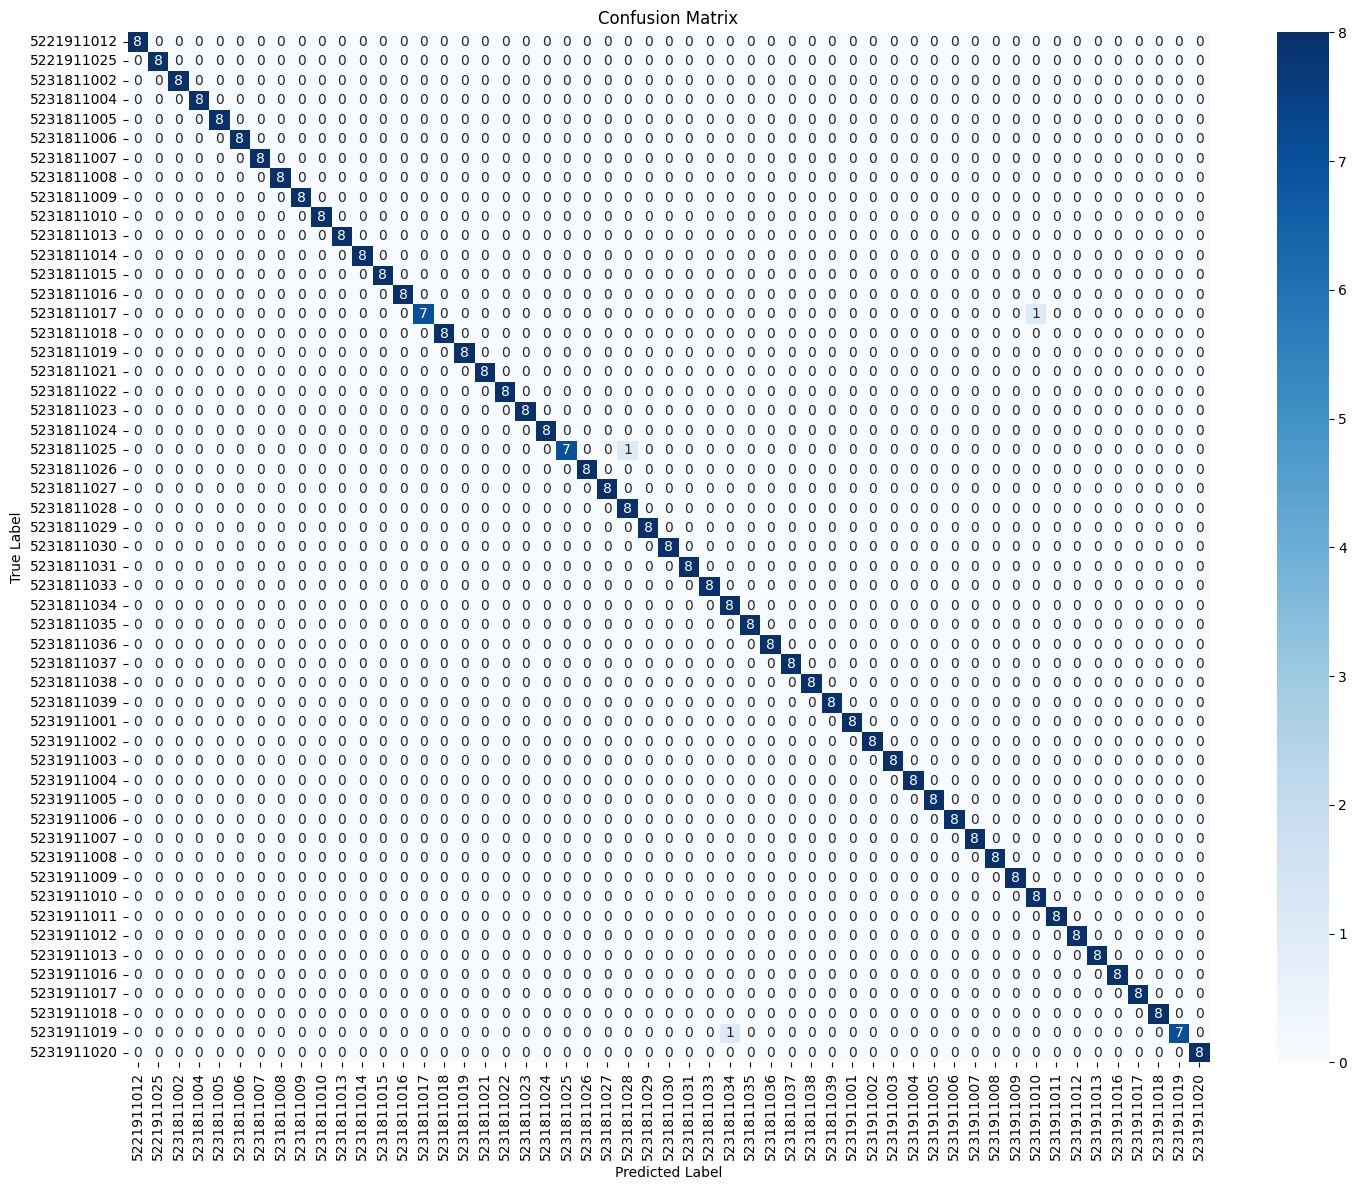

In [24]:
# Get predictions on the test data
print("Generating predictions on test data...")
test_generator.reset() # Ensure the generator is at the beginning
predictions = model.predict(test_generator) # Removed steps
predicted_classes = np.argmax(predictions, axis=1)

# Get true labels
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys()) # Get class names in the same order as indices

# Generate Classification Report
print("\nClassification Report:")
# Use true_classes directly as predictions should now match the number of samples
report = classification_report(true_classes, predicted_classes, target_names=class_labels)
print(report)

# Generate Confusion Matrix
print("\nConfusion Matrix:")
# Use true_classes directly as predictions should now match the number of samples
cm = confusion_matrix(true_classes, predicted_classes)

# Plot Confusion Matrix
plt.figure(figsize=(15, 12))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

## **Section 7: Prediction on Sample Images (Prediksi pada Gambar Sampel)**

**Penjelasan:** Melakukan prediksi pada beberapa gambar acak dari data tes dan menampilkan hasilnya secara visual untuk melihat bagaimana performa model pada kasus individu.

### **7.1. Visualize Predictions (Visualisasi Prediksi)**

**Penjelasan:** Mengambil satu batch gambar dari test generator, melakukan prediksi menggunakan model, dan menampilkan gambar beserta label prediksi dan label aslinya. Prediksi yang benar akan diberi warna hijau, sedangkan yang salah diberi warna merah.

In [ ]:
# Get one batch of test data
test_generator.reset() # Ensure the generator is at the beginning
x_test_batch, y_test_batch = next(test_generator)

# Get predictions for this batch
predictions_batch = model.predict(x_test_batch)
predicted_classes_batch = np.argmax(predictions_batch, axis=1)
true_classes_batch = np.argmax(y_test_batch, axis=1)

# Get class labels
class_labels = list(test_generator.class_indices.keys())

# Visualize predictions
plt.figure(figsize=(15, 15))
num_images_to_show = min(len(x_test_batch), 25) # Show up to 25 images from the batch

for i in range(num_images_to_show):
    plt.subplot(5, 5, i + 1) # Adjust grid size as needed
    plt.imshow(x_test_batch[i]) # Images are already rescaled to [0, 1]
    plt.axis('off')

    true_label = class_labels[true_classes_batch[i]]
    predicted_label = class_labels[predicted_classes_batch[i]]

    # Set title color based on prediction correctness
    color = 'green' if true_classes_batch[i] == predicted_classes_batch[i] else 'red'

    plt.title(f"True: {true_label}\nPred: {predicted_label}", color=color, fontsize=10)

plt.tight_layout()
plt.show()